[1. 1. 0. 0.]
t: 0.0, survival_probability: 1.0
t: 0.05, survival_probability: 0.9996901419237161
t: 0.1, survival_probability: 0.9987604880858784
t: 0.15000000000000002, survival_probability: 0.9971941812836727
t: 0.2, survival_probability: 0.99502250784865
t: 0.25, survival_probability: 0.9922927754208211
t: 0.30000000000000004, survival_probability: 0.9889694783923698
t: 0.35000000000000003, survival_probability: 0.9850785891950226
t: 0.4, survival_probability: 0.9807060855338053
t: 0.45, survival_probability: 0.9758082421730833
t: 0.5, survival_probability: 0.9704508758421436
t: 0.55, survival_probability: 0.964736702035347
t: 0.6000000000000001, survival_probability: 0.9585718020513007
t: 0.65, survival_probability: 0.9520197237631868
t: 0.7000000000000001, survival_probability: 0.9453186970620144
t: 0.75, survival_probability: 0.9381524553481158
t: 0.8, survival_probability: 0.9309030023414595
t: 0.8500000000000001, survival_probability: 0.9234152000303151
t: 0.9, survival_probab

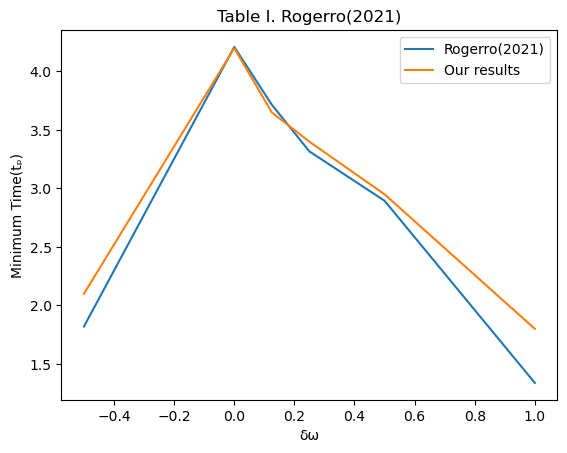

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.linalg import expm
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector, Operator
import sys
import os

# Determine the correct path for the 'src' directory
if '__file__' in globals():
    # Running as a script
    src_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'src'))
else:
    # Running in an interactive environment like Jupyter Notebook
    src_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

sys.path.append(src_dir)

from hamiltonian import construct_hamiltonian
from evolve import evolve_and_measure_circuit
from constants import hbar, c, eV, MeV, GeV, G_F, kB

# this file plots δω on x axis while minimum time tp on y axis and compares
# the values of our calculations with Rogerros calculations in Table I.
# Here symmetric δω is used i.e. ω_a = - ω_b for a given δω plotted on x axis.

N_sites = 4
ttotal = 5

def main(Δω, N_sites, ttotal):
    cutoff = 1E-14
    τ = 0.05
    times = np.arange(0, ttotal, τ)  # Define time steps
    tolerance = 5E-1
    Δx = 1E-3
    L = 10  # cm # not being used in this test but defined to keep the evolve function arguments consistent.
    Δp = L  # width of shape function # not being used in this test but defined to keep the evolve function arguments consistent.
    t1 = 0.0084003052  # choose initial time for growth rate calculation #variable, not being used in this test
    t2 = 0.011700318  # choose final time for growth rate calculation #variable, not being used in this test
    periodic = False
    if Δω == -0.5:
        a_t, b_t, c_t = 0, 0, 1.82
    elif Δω == 0.0:
        a_t, b_t, c_t = 0.0, 2.105, 0
    elif Δω == 0.05:
        a_t, b_t, c_t = 2.586, 0, 0
    elif Δω == 0.125:
        a_t, b_t, c_t = 1.656, 0, 1.42
    elif Δω == 0.25:
        a_t, b_t, c_t = 1.224, 0, 1.62
    elif Δω == 0.5:
        a_t, b_t, c_t = 1.064, 0, 1.42
    elif Δω == 1.0:
        a_t, b_t, c_t = 0.965, 0, 0
    
    delta_m_squared = - 2 * Δω  # added - sign to fulfill requirement of collective osc rog, still needs rechecking
    omega_a = np.full(N_sites // 2, delta_m_squared)
    omega_b = np.zeros(N_sites // 2)
    omega = np.concatenate((omega_a, omega_b))
    print(omega)
    shots = 50245584
    backend = AerSimulator(method='automatic')
    mu = 1
    # Create an array of dimension N and fill it with the value 1/(sqrt(2) * G_F). This is the number of neutrinos.
    N = mu * np.full(N_sites, (Δx**3) / (np.sqrt(2) * G_F * N_sites))
    theta_nu = 0  # mixing_angle #rad
    B = [np.sin(2 * theta_nu), 0, -np.cos(2 * theta_nu)]  # is equivalent to B = [0, 0, -1] # fixed for Rogerro's case
    B = B / np.linalg.norm(B)

    # Generate x, y, and z arrays
    x = np.random.rand(N_sites)
    y = np.random.rand(N_sites)
    z = np.zeros(N_sites)
    
    def generate_p_array(N_sites):
        half_N_sites = N_sites // 2
        p_array = np.concatenate((np.full(half_N_sites, 1), np.full(half_N_sites, 1)))
        return p_array

    p_array = generate_p_array(N_sites)

    # Create the p matrix with numbers generated from the p_array for the first component and zeros for the other components (x, y, z)
    p = np.column_stack((p_array, np.zeros(N_sites), np.zeros(N_sites)))

    # All of the sites are neutrinos, energy_sign array
    energy_sign = np.ones(N_sites)
    # modify this shape_name dict thing
    shape_name = 1  # variable.  #Select a shape function based on the shape_name variable form the list defined in dictionary in shape_func file
    
    H = construct_hamiltonian(N, omega, B, N_sites, Δx, delta_m_squared, p, x, Δp, theta_nu, shape_name, L, τ, energy_sign)
    # Simulation and expected value calculation
    sigma_z_values = []
    survival_probabilities = []

    for t in times:
        qc = evolve_and_measure_circuit(t, H, N_sites)
        result = backend.run(qc, shots=shots).result()    
        counts = result.get_counts(qc)
        
        # Calculate expectation value of sigma_z for the first qubit
        sigma_z = 0
        for outcome, count in counts.items():
            if outcome[0] == '0':
                sigma_z += count / shots
            else:
                sigma_z -= count / shots
        
        # Calculate survival probability
        survival_probability = (1 - sigma_z) / 2
        print(f"t: {t}, survival_probability: {survival_probability}")
        
        # Append values to the respective lists
        sigma_z_values.append(sigma_z)
        survival_probabilities.append(survival_probability)

    def find_first_local_minima_index(arr):
        n = len(arr)
        for i in range(1, n - 1):
            if arr[i] < arr[i - 1] and arr[i] < arr[i + 1]:
                return i
        return -1

    # Index of the first minimum of the survival probabilities
    i_first_local_min = find_first_local_minima_index(survival_probabilities)

    # Writing if_else statement to communicate if local minima (not) found
    if i_first_local_min != -1:
        print(f"Index of the first local minimum: {i_first_local_min}")
    else:
        print("No local minimum found in the array.")
        
    # Time at which the first minimum survival probability is reached
    t_min = τ * i_first_local_min
    print(f"Corresponding time of first minimum index= {t_min}")
    
    t_p_Rog = a_t * np.log(N_sites) + b_t * np.sqrt(N_sites) + c_t
    print("t_p_Rog= ", t_p_Rog)
    # Check that our time of first minimum survival probability compared to Rogerro(2021) remains within the timestep and tolerance.
    # assert abs(t_min - t_p_Rog) < τ + tolerance
    return t_p_Rog, t_min

# Arrays to store t_p_Rog and t_min for each Δω
Δω_values = [-0.5, 0.0, 0.125, 0.25, 0.5, 1.0]
t_p_Rog_array = []
t_min_array = []

datadir = os.path.join(os.getcwd(), "..", "misc", "datafiles", "Rog", f"par_{N_sites}", f"tt_{ttotal}")
if not os.path.isdir(datadir):
    os.makedirs(datadir)

for Δω in Δω_values:
    t_p_Rog, t_min = main(Δω, N_sites, ttotal)
    t_p_Rog_array.append(t_p_Rog)
    t_min_array.append(t_min)

fname1 = os.path.join(datadir, "δω_tpRog_tpmine.dat")
np.savetxt(fname1, np.column_stack((Δω_values, t_p_Rog_array, t_min_array)))

plotdir = os.path.join(os.getcwd(), "..", "misc", "plots", "Rog", f"par_{N_sites}", f"tt_{ttotal}")
if not os.path.isdir(plotdir):
    os.makedirs(plotdir)

# Create the plot
plt.plot(Δω_values, t_p_Rog_array, label="Rogerro(2021)")
plt.plot(Δω_values, t_min_array, label="Our results")
plt.xlabel("δω")
plt.ylabel("Minimum Time(tₚ)")
plt.title("Table I. Rogerro(2021)")
plt.legend()
plt.savefig(os.path.join(plotdir, f"t_p_vs_symmetric_del_omega_for_N_sites{N_sites}.pdf"))
plt.show()
